# Машинное обучение
## Лабораторная работа №3

Выполнил студент группы 15-В-2   
Тутаев Роман   
Вариант №14

In [11]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import (cross_val_score, StratifiedKFold,
                                     train_test_split)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from scipy.stats import pearsonr, spearmanr

### 1.	Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных 

Набор данных содержит информацию о работе электростанции

| Переменная   | Описание  | Параметр  | 
|--------------|--------------|-------------------|
|AT|средняя температура| вещественный|
|V|отработка|вещественный|
|AP|давление окружающей среды|вещественный|
|RH|относительная влажность|вещественный|
|PE|произведенная электроэнергия|вещественный|

Нужно предсказать количество произведенной энергии

In [38]:
df = pd.read_csv('Folds5x2_pp.csv')
df.head()

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


In [39]:
print('dataset size: ', df.shape)
df.count()

dataset size:  (9568, 5)


AT    9568
V     9568
AP    9568
RH    9568
PE    9568
dtype: int64

### 2.	Удалите дубликаты строк в наборе данных; приведите размер набора данных до и после данной операции

In [40]:
print('dataset size before reduce: ', df.shape)

df = df.drop_duplicates()
df = df.dropna().reset_index(drop=True)
print('dataset size: ', df.shape)

dataset size before reduce:  (9568, 5)
dataset size:  (9527, 5)


### 3.	Выполните масштабирование количественных признаков; Постройте диаграммы BoxPlot для признаков до и после масштабирования. Выберите способ масштабирования (например, нормализацию или стандартизацию

In [42]:
numerical_columns = [i for i in df.columns if df[i].dtype.name != 'object']
categorial_columns = [i for i in df.columns if df[i].dtype.name == 'object']

print('numerical: ', numerical_columns)
print('categorial: ', categorial_columns)

numerical:  ['AT', 'V', 'AP', 'RH', 'PE']
categorial:  []


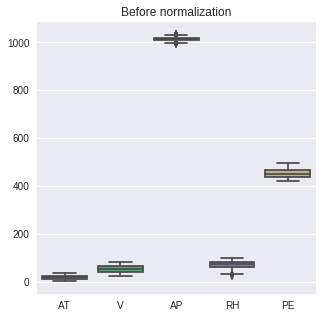

In [44]:
plt.figure(figsize=(5,5))
sns.boxplot(data=df[numerical_columns])
plt.title("Before normalization")
plt.show()

In [46]:
scaler = MinMaxScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
df.head()

,AT,V,AP,RH,PE
0,0.184986,0.274199,0.444197,0.863941,0.797616
1,0.618414,0.589502,0.458055,0.652011,0.337616
2,0.791218,0.561210,0.352883,0.219169,0.245033
3,0.488952,0.432918,0.354615,0.686729,0.434834
4,0.283003,0.272242,0.599852,0.960322,0.585033


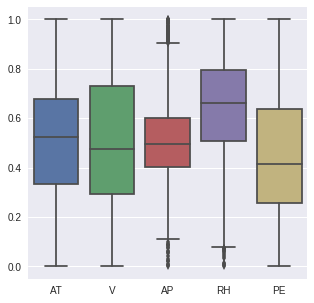

In [47]:
plt.figure(figsize=(5,5))
sns.boxplot(data=df[numerical_columns])
plt.show()

### 4.	Выполните замену категориальных признаков; выберите и обоснуйте способ замены
В наборе нет категориальных признаков (см. пункт 3)

### 5.	Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других

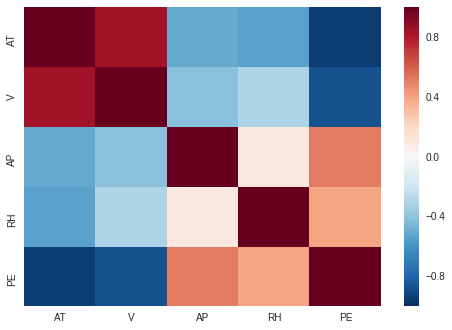

In [50]:
df_corr = df.corr()
sns.heatmap(df_corr)
plt.show()

In [51]:
df_corr

,AT,V,AP,RH,PE
AT,1.000000,0.843689,-0.508222,-0.543947,-0.947908
V,0.843689,1.000000,-0.415718,-0.312214,-0.869900
AP,-0.508222,-0.415718,1.000000,0.101631,0.518687
RH,-0.543947,-0.312214,0.101631,1.000000,0.391175
PE,-0.947908,-0.869900,0.518687,0.391175,1.000000


### 6.	Заполните пропущенные значения в данных

In [52]:
print('dataset size: ', df.shape)
df.count()

dataset size:  (9527, 5)


AT    9527
V     9527
AP    9527
RH    9527
PE    9527
dtype: int64

### 7.	Решите поставленную задачу регрессии в соответствии с заданием. 
 * Линейная регрессия без использования регуляризаторов
 * Линейная регрессия, LASSO регуляризатор

In [87]:
X, y = df.drop('PE', axis=1), df['PE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 231)

Линейная регрессия без использования регуляризаторов

In [88]:
from scipy.stats import t
import scipy as sc
class LinearRegression(linear_model.LinearRegression):

    def __init__(self,*args,**kwargs):
        # *args is the list of arguments that might go into the LinearRegression object
        # that we don't know about and don't want to have to deal with. Similarly, **kwargs
        # is a dictionary of key words and values that might also need to go into the orginal
        # LinearRegression object. We put *args and **kwargs so that we don't have to look
        # these up and write them down explicitly here. Nice and easy.

        if not "fit_intercept" in kwargs:
            kwargs['fit_intercept'] = False

        super(LinearRegression,self).__init__(*args,**kwargs)

    # Adding in t-statistics for the coefficients.
    def fit(self,x,y):
        # This takes in numpy arrays (not matrices). Also assumes you are leaving out the column
        # of constants.

        # Not totally sure what 'super' does here and why you redefine self...
        self = super(LinearRegression, self).fit(x,y)
        n, k = x.shape
        yHat = np.matrix(self.predict(x)).T

        # Change X and Y into numpy matricies. x also has a column of ones added to it.
        x = np.hstack((np.ones((n,1)),np.matrix(x)))
        y = np.matrix(y).T

        # Degrees of freedom.
        df = float(n-k-1)

        # Sample variance.     
        sse = np.sum(np.square(yHat - y),axis=0)
        self.sampleVariance = sse/df

        # Sample variance for x.
        self.sampleVarianceX = x.T*x

        # Covariance Matrix = [(s^2)(X'X)^-1]^0.5. (sqrtm = matrix square root.  ugly)
        self.covarianceMatrix = sc.linalg.sqrtm(self.sampleVariance[0,0]*self.sampleVarianceX.I)

        # Standard erros for the difference coefficients: the diagonal elements of the covariance matrix.
        self.se = self.covarianceMatrix.diagonal()[1:]

        # T statistic for each beta.
        self.betasTStat = np.zeros(len(self.se))
        for i in range(len(self.se)):
            self.betasTStat[i] = self.coef_[i]/self.se[i]

        # P-value for each beta. This is a two sided t-test, since the betas can be 
        # positive or negative.
        self.betasPValue = 1 - t.cdf(abs(self.betasTStat),df)

In [89]:
regr = LinearRegression()
regr.fit(X_train,y_train)
pred = regr.predict(X_test)
print(pred[:10] - y_test[:10])

662    -0.013286
6494    0.107206
8092   -0.123222
2512   -0.117509
2585    0.076383
6858    0.019200
7671   -0.092468
4630   -0.126135
1827    0.123214
9430    0.175601
Name: PE, dtype: float64


In [93]:
regr.intercept_

0.0

In [91]:
corr = {}
corr['pearson'], _ = pearsonr(pred, y_test)
corr['spearman'], _ = spearmanr(pred, y_test)
print('pearson correlation: ', corr['pearson'])
print('spearmen correlation: ', corr['spearman'])

pearson correlation:  0.822438226246
spearmen correlation:  0.847433791601


In [92]:
print('p-value: ', regr.betasPValue[0])

p-value:  0.36521830239


утверждение что производимую энергию(PE) можно выяснить с нашим набором данных, не верно с вероятностью 0.365, что выше допустимого значения 0.05-0.1

Линейная регрессия, LASSO регуляризатор

In [76]:
regr = linear_model.Lasso (alpha = 0.1)
regr.fit (X_train, y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [78]:
regr.coef_

array([-0., -0.,  0.,  0.])

In [80]:
pred = regr.predict(X_test)
print(pred[:10])

[ 0.45099026  0.45099026  0.45099026  0.45099026  0.45099026  0.45099026
  0.45099026  0.45099026  0.45099026  0.45099026]


In [81]:
print(y_test[:10])

662     0.272053
6494    0.565563
8092    0.069404
2512    0.548874
2585    0.733775
6858    0.319073
7671    0.168079
4630    0.381325
1827    0.796026
9430    0.256954
Name: PE, dtype: float64


In [82]:
print(pred[:10]-y_test[:10])

662     0.178937
6494   -0.114573
8092    0.381586
2512   -0.097884
2585   -0.282785
6858    0.131917
7671    0.282911
4630    0.069666
1827   -0.345036
9430    0.194037
Name: PE, dtype: float64


In [84]:
regr.intercept_

0.45099025890186201